<h1 style="text-align: center;">RNN<br>Product Amount Forecast by Time<br><h1>

# Dataset Info

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

# Indest Data

In [3]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True)

# Exploratory Data Analysis and Visualization

1. We implement basic steps to see how is our data looks like
2. We change the column name as "Production"
2. We plot your data and see its seasonalty

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [6]:
df.columns = ['Production']

In [7]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


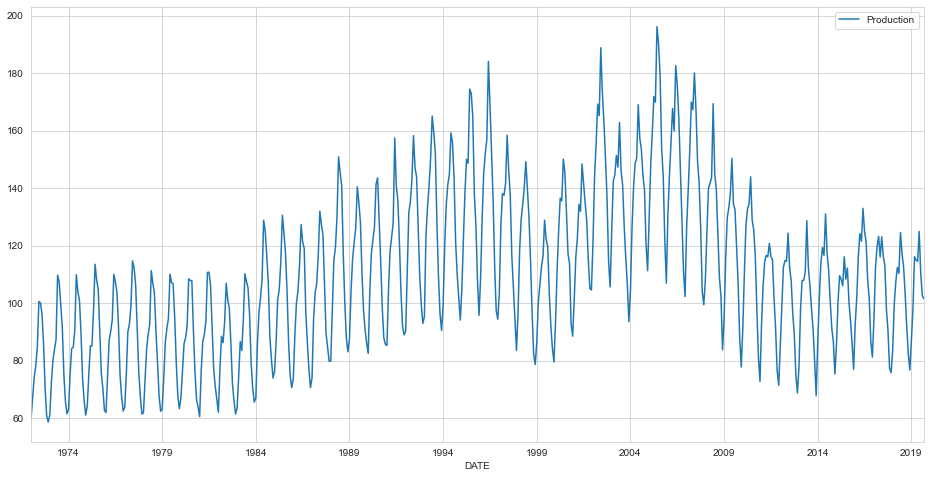

In [10]:
df.plot(figsize=(16,8))
plt.show()

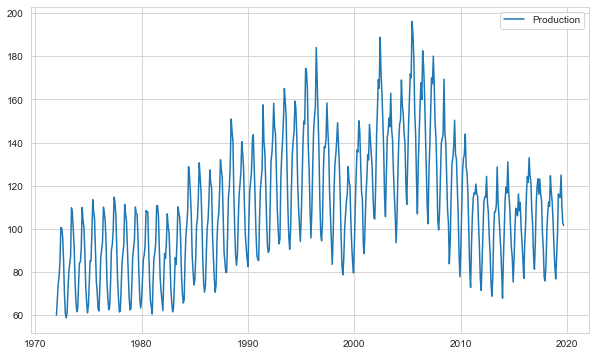

In [23]:
plt.plot(df, label="Production")
plt.legend()
plt.show()

In [11]:
df.shape

(573, 1)

# Preprocessing of Data

## Train Test Split

In [24]:
test_size = 24

In [25]:
test_ind = len(df)- test_size

In [26]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

## Scaling

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
scaler = MinMaxScaler()

In [29]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [30]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [32]:
X, y = generator[0]

In [33]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


# Modelling & Model Performance

## with "tanh" activation function

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
n_features = train_scaled.shape[1]

In [36]:
model = Sequential()
model.add(LSTM(64, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'tanh', return_sequences=True))
model.add(LSTM(16, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [38]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [39]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 36s 42ms/step - loss: 0.0278 - val_loss: 0.0093
Epoch 2/20
537/537 [==============================] - 19s 35ms/step - loss: 0.0156 - val_loss: 0.0030
Epoch 3/20
537/537 [==============================] - 20s 38ms/step - loss: 0.0114 - val_loss: 0.0053
Epoch 4/20
537/537 [==============================] - 19s 35ms/step - loss: 0.0080 - val_loss: 0.0031
Epoch 5/20
537/537 [==============================] - 18s 33ms/step - loss: 0.0059 - val_loss: 0.0017
Epoch 6/20
537/537 [==============================] - 22s 41ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 7/20
537/537 [==============================] - 17s 32ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 8/20
537/537 [==============================] - 17s 31ms/step - loss: 0.0053 - val_loss: 0.0038


<AxesSubplot:>

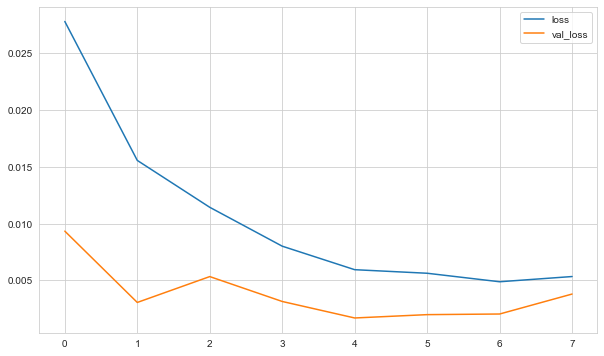

In [40]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [42]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [43]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

1/1 [==============================] - 0s 57ms/step


### Inverse Transformation and Comparing

In [44]:
predictions = scaler.inverse_transform(predictions_scaled)

In [45]:
compare = test[:12]
compare['Predictions_tanh'] = predictions
compare

,Production,Predictions_tanh
DATE,,
2017-10-01,90.473,91.110
2017-11-01,77.438,84.351
2017-12-01,75.812,88.881
2018-01-01,83.434,101.006
2018-02-01,99.490,111.243
2018-03-01,107.315,116.289
2018-04-01,112.431,119.332
2018-05-01,110.354,120.172
2018-06-01,124.584,121.460


<AxesSubplot:xlabel='DATE'>

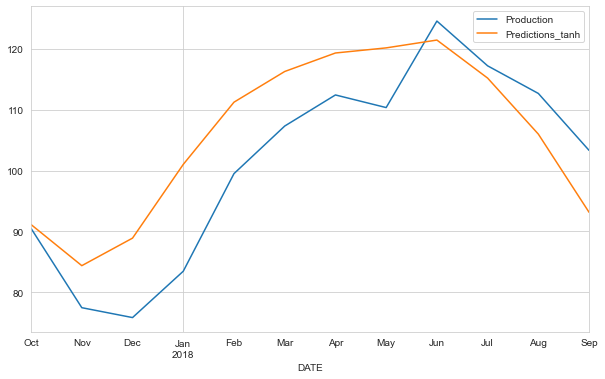

In [46]:
compare.plot()

In [47]:
eval_metrics(compare.Production, compare.Predictions_tanh)

r2_score: 0.6279717400003213 
mae: 8.137818850589044 
mse: 87.73195952853393 
rmse: 9.36653401897062


## with "relu" activation function

In [48]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 64)            16896     
                                                                 
 lstm_4 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [50]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [51]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 22s 27ms/step - loss: 0.0330 - val_loss: 0.0077
Epoch 2/20
537/537 [==============================] - 13s 25ms/step - loss: 0.0155 - val_loss: 0.0096
Epoch 3/20
537/537 [==============================] - 14s 25ms/step - loss: 0.0078 - val_loss: 0.0017
Epoch 4/20
537/537 [==============================] - 14s 25ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 5/20
537/537 [==============================] - 13s 25ms/step - loss: 0.0073 - val_loss: 0.0027
Epoch 6/20
537/537 [==============================] - 14s 26ms/step - loss: 0.0075 - val_loss: 0.0022


<AxesSubplot:>

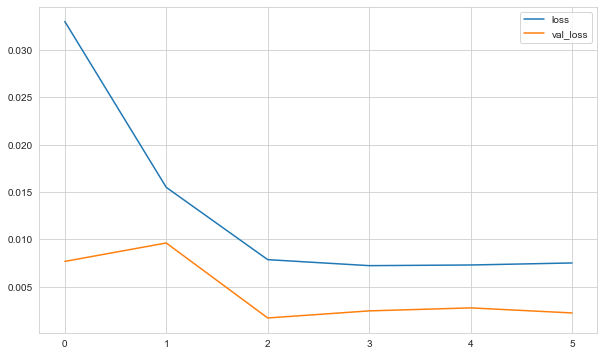

In [52]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [53]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

1/1 [==============================] - 0s 48ms/step


### Inverse Transformation and Comparing

In [54]:
predictions = scaler.inverse_transform(predictions_scaled)

In [55]:
compare['Predictions_relu'] = predictions
compare

,Production,Predictions_tanh,Predictions_relu
DATE,,,
2017-10-01,90.473,91.110,101.729
2017-11-01,77.438,84.351,86.575
2017-12-01,75.812,88.881,87.730
2018-01-01,83.434,101.006,101.806
2018-02-01,99.490,111.243,115.650
2018-03-01,107.315,116.289,121.595
2018-04-01,112.431,119.332,120.945
2018-05-01,110.354,120.172,121.279
2018-06-01,124.584,121.460,123.146


<AxesSubplot:xlabel='DATE'>

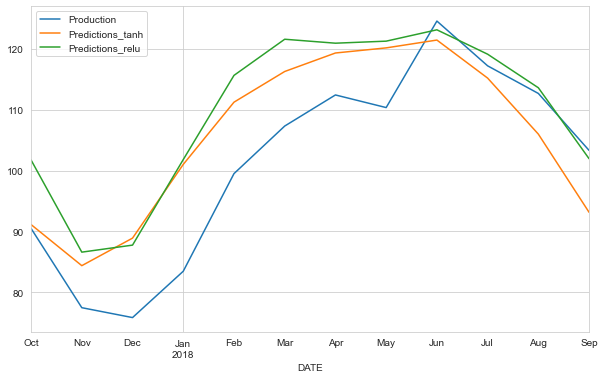

In [56]:
compare.plot()

In [57]:
eval_metrics(compare.Production, compare.Predictions_relu)

r2_score: 0.5211501610611395 
mae: 8.851261582435665 
mse: 112.92269756621546 
rmse: 10.626509190049923


# Retrain and Forecasting

We select activation function providing a better score, create our final model with full data, forecast for the next 12 months, and plot this forecast.

In [58]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [59]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [60]:
model = Sequential()

model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=10)

Epoch 1/10
561/561 [==============================] - 20s 24ms/step - loss: 0.0303
Epoch 2/10
561/561 [==============================] - 14s 26ms/step - loss: 0.0124
Epoch 3/10
561/561 [==============================] - 14s 25ms/step - loss: 0.0093
Epoch 4/10
561/561 [==============================] - 14s 25ms/step - loss: 0.0074
Epoch 5/10
561/561 [==============================] - 14s 25ms/step - loss: 0.0066
Epoch 6/10
561/561 [==============================] - 14s 25ms/step - loss: 0.0065
Epoch 7/10
561/561 [==============================] - 14s 25ms/step - loss: 0.0066
Epoch 8/10
561/561 [==============================] - 14s 25ms/step - loss: 0.0065
Epoch 9/10
561/561 [==============================] - 14s 24ms/step - loss: 0.0063
Epoch 10/10
561/561 [==============================] - 14s 24ms/step - loss: 0.0061


In [61]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

1/1 [==============================] - 0s 49ms/step


In [62]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[100.87784339],
       [ 89.84472238],
       [ 87.57767792],
       [ 96.96980883],
       [109.80637802],
       [118.64600147],
       [118.70801594],
       [122.52737702],
       [125.34365854],
       [117.35736519],
       [112.09440953],
       [111.07583046]])

In [63]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [64]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [65]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-10-01,100.878
2019-11-01,89.845
2019-12-01,87.578
2020-01-01,96.970
2020-02-01,109.806
2020-03-01,118.646
2020-04-01,118.708
2020-05-01,122.527
2020-06-01,125.344
2020-07-01,117.357


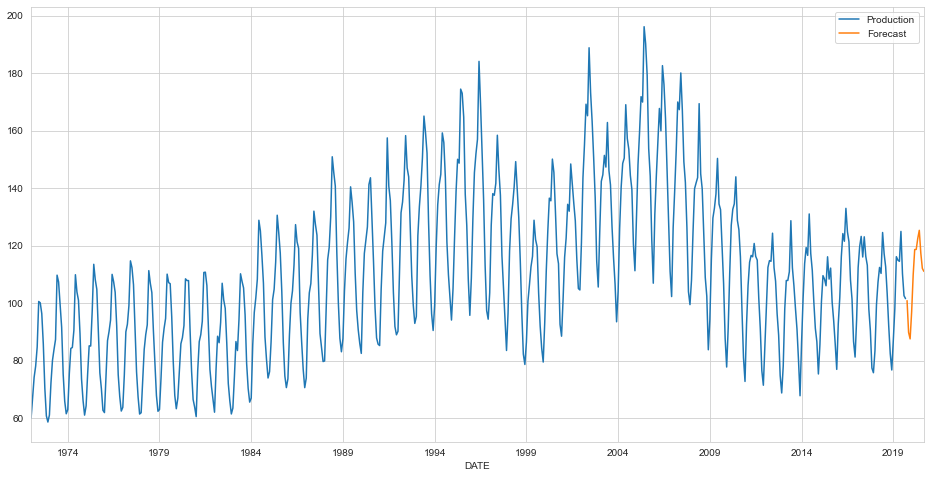

In [66]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

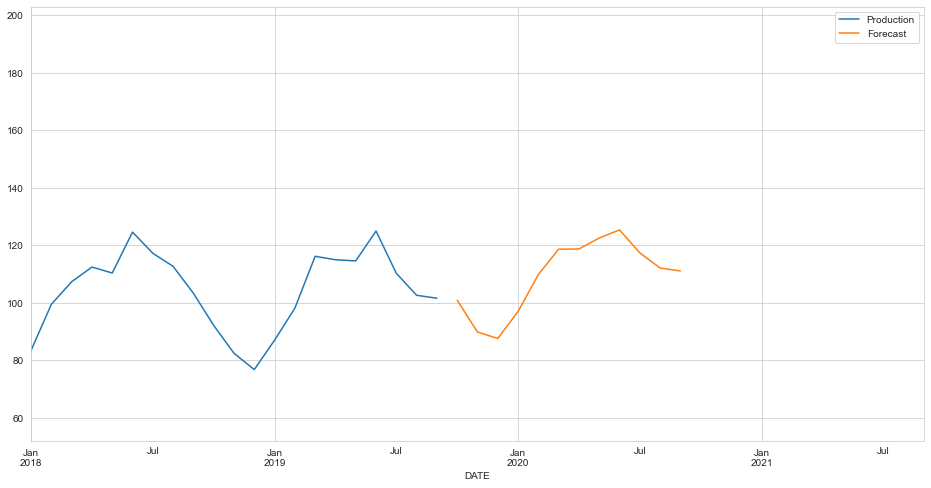

In [67]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')

In [69]:
dataset_total = pd.concat((df['Production'], forecast_df['Forecast']), axis=0)

<AxesSubplot:>

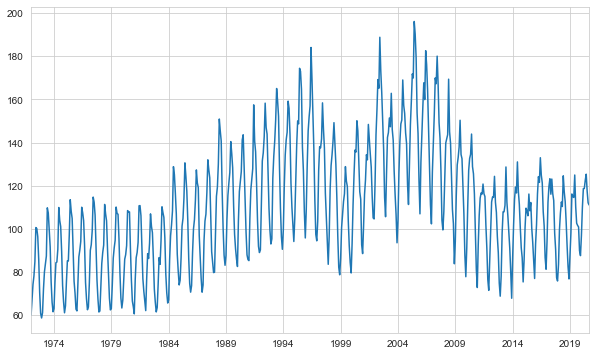

In [70]:
dataset_total.plot()

(576.0, 620.0)

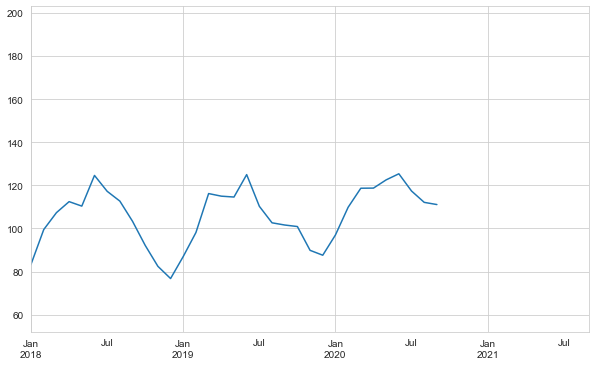

In [71]:
dataset_total.plot()
plt.xlim('2018-01-01', '2021-09-01')